# Chapter 10 - Statistics for Tree-Based Methods

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Overview

In [4]:
url1 = ('https://raw.githubusercontent.com/PacktPublishing/Essential-Statistics-for-Non-STEM-Data-Analysts/refs/heads/master/Chapter09/strok_risk.csv')

df = pd.read_csv(url1)

df

,weight,high_oil_diet,smoking,stroke_risk
0,low,yes,no,low
1,low,no,yes,low
2,high,yes,yes,high
3,middle,no,no,low
4,high,yes,yes,high
5,high,no,yes,high
6,low,yes,no,middle
7,low,no,yes,low
8,low,no,no,low
9,middle,no,yes,high


In [5]:
# Convert 'stroke_risk' column to binary categories: stroke_risk = "middle" becomes "high"
df["stroke_risk"] = df["stroke_risk"].apply(lambda x: "low" if x == "low" else "high")

df

,weight,high_oil_diet,smoking,stroke_risk
0,low,yes,no,low
1,low,no,yes,low
2,high,yes,yes,high
3,middle,no,no,low
4,high,yes,yes,high
5,high,no,yes,high
6,low,yes,no,high
7,low,no,yes,low
8,low,no,no,low
9,middle,no,yes,high


In [6]:
from collections import Counter

Counter(df["stroke_risk"])

Counter({'low': 8, 'high': 7})

In [7]:
def gini(counter):                                # Define a function to calculate the Gini impurity
    total = sum(counter.values())                 # Calculate the total count of all items in the counter
    ret = 1                                       # Initialize the Gini impurity to 1
    for key, val in counter.items():              # Loop through each key-value pair in the counter
        ret -= (val / total) ** 2                 # Subtract the squared proportion of each category from Gini impurity
    return ret                                    # Return the calculated Gini impurity

#### High oil diet

In [9]:
Counter(df[df["high_oil_diet"] == "yes"]["stroke_risk"])  # Count occurrences of each 'stroke_risk' category 
                                                          # for rows where 'high_oil_diet' equals 'yes'

Counter({'high': 4, 'low': 2})

There is a total of six records with two low-risk records and four high-risk records (4/6 = 2/3 and 2/6 = 1/3).

Therefore, the impurity for the high-oil diet group is:

$$
1 - \left(\frac{1}{3}\right)^2 - \left(\frac{2}{3}\right)^2 = \frac{4}{9}
$$

In [11]:
Counter(df[df["high_oil_diet"] == "no"]["stroke_risk"])   # Count occurrences of each 'stroke_risk' category 
                                                          # for rows where 'high_oil_diet' equals 'yes'

Counter({'low': 6, 'high': 3})

#### Smoking

In [13]:
Counter(df[df["smoking"] == "yes"]["stroke_risk"])        # Count occurrences of each 'stroke_risk' category 
                                                          # for rows where 'smoking' equals 'yes'

Counter({'high': 5, 'low': 2})

In [14]:
Counter(df[df["smoking"] == "no"]["stroke_risk"])         # Count occurrences of each 'stroke_risk' category 
                                                          # for rows where 'smoking' equals 'no'

Counter({'low': 6, 'high': 2})

#### Weight

In [16]:
Counter(df[df["weight"]=="low"]["stroke_risk"])           # Count occurrences of each 'stroke_risk' category 
                                                          # for rows where 'weight' equals 'low'

Counter({'low': 4, 'high': 1})

In [17]:
# Calculate the gini impurity for 'weight' equals 'low'
gini(Counter(df[df["weight"]=="low"]["stroke_risk"]))

0.31999999999999984

In [18]:
Counter(df[df["weight"]!="low"]["stroke_risk"])           # Count occurrences of each 'stroke_risk' category 
                                                          # for rows where 'weight' different to 'low'

Counter({'high': 6, 'low': 4})

In [19]:
# Calculate the gini impurity for 'weight' different to 'low'
gini(Counter(df[df["weight"]!="low"]["stroke_risk"]))

0.48

In [20]:
0.32*1/3 + 0.48*2/3

0.4266666666666667

# Regression Tree

#### Create artificial data

In [23]:
# Define a function to calculate revenue based on price
def price_2_revenue(price):              
    
    if price < 85:                               # Case 1: Price is less than 85
        return 70 * abs(price - 75)              # Revenue is proportional to the absolute difference from 75
        
    elif price < 95:                             # Case 2: Price is between 85 and 95
        return 10 * 80                           # Revenue is fixed at 800
        
    else:                                        # Case 3: Price is 95 or greater
        return 80 * (105 - price)                # Revenue decreases as price approaches 105

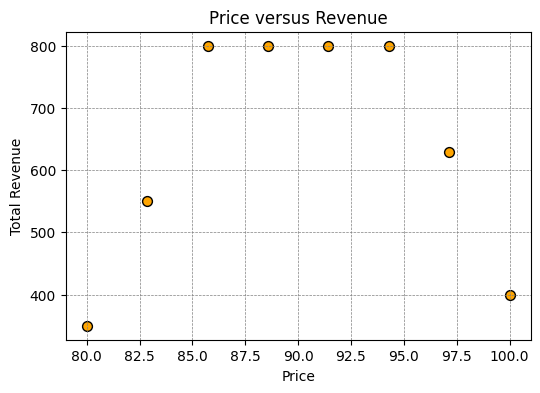

In [24]:
prices = np.linspace(80, 100, 8)                        # Generate an array of prices ranging from 80 to 100 with 8 evenly spaced values

revenue = np.array([price_2_revenue(price) for price in prices])  # Calculate the revenue for each price using the price_2_revenue function

plt.figure(figsize=(6, 4))                              # Create a figure with a specified size

plt.scatter(prices,                                     # x-coordinates for the scatter plot (prices)
            revenue,                                    # y-coordinates for the scatter plot (revenue)
            color='orange',                             # Set marker color to orange
            s=50,                                       # Set marker size to 50
            edgecolor='black')                          # Add black edges around the markers


plt.xlabel("Price")                                     # Label the x-axis
plt.ylabel("Total Revenue")                             # Label the y-axis
plt.title("Price versus Revenue")                       # Add a title

plt.grid(visible=True, linestyle='--', linewidth=0.5, color='grey')  # Add grid lines

plt.show()                                              # Display the plot

In [25]:
pd.DataFrame({"Price":prices,"Revenue":revenue})

,Price,Revenue
0,80.000000,350.000000
1,82.857143,550.000000
2,85.714286,800.000000
3,88.571429,800.000000
4,91.428571,800.000000
5,94.285714,800.000000
6,97.142857,628.571429
7,100.000000,400.000000


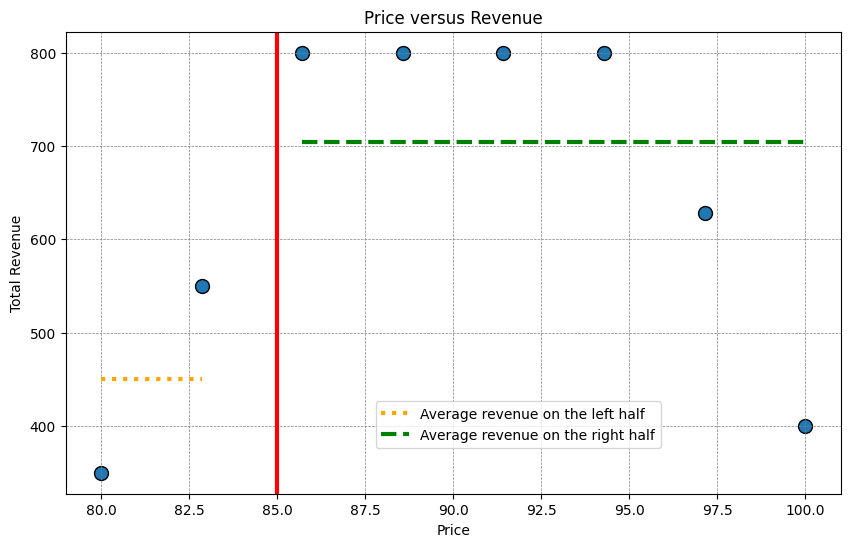

In [26]:
plt.figure(figsize=(10, 6))                            # Set the figure size

plt.scatter(prices, revenue, s=100, edgecolor='black') # Create a scatter plot

plt.xlabel("Price")                                    # Label for the x-axis
plt.ylabel("Total Revenue")                            # Label for the y-axis
plt.title("Price versus Revenue")                      # Title for the plot

threshold = 85                                         # Define the threshold price value
num_left = sum(prices < threshold)                     # Count the number of prices less than the threshold
ave_left = np.mean(revenue[prices < threshold])        # Calculate the average revenue for prices below the threshold
num_right = sum(prices > threshold)                    # Count the number of prices greater than the threshold
ave_right = np.mean(revenue[prices > threshold])       # Calculate the average revenue for prices above the threshold

plt.axvline(threshold, color="red", linewidth=3)       # Add a vertical line at the threshold with red color and thick width

# Plot the average revenue line for prices below the threshold
plt.plot(prices[prices < threshold], 
         [ave_left for _ in range(num_left)], 
         linewidth=3, linestyle=":", color="orange", 
         label="Average revenue on the left half")

# Plot the average revenue line for prices above the threshold
plt.plot(prices[prices > threshold], 
         [ave_right for _ in range(num_right)], 
         linewidth=3, linestyle="--", color="green", 
         label="Average revenue on the right half")

plt.legend(loc=[0.4, 0.1])                             # Add legend and position it in the plot

plt.grid(visible=True, linestyle='--', linewidth=0.5, color='grey')  # Add grid lines

plt.show()                                             # Display the plot

*Splitting at price 85.0*

#### Predicted revenue for both sides

In [29]:
print(f' Average Revenue on the left half: {ave_left:.2f}')
print(f'Average Revenue on the right half: {ave_right:.2f}')

 Average Revenue on the left half: 450.00
Average Revenue on the right half: 704.76


In [30]:
# Define a function to calculate the sum of squared residuals (SSR) for an array
def cal_ssr(arr):      
    
    if len(arr) == 0:                         # Check if the array is empty
        return 0                              # If empty, return 0 as SSR
    ave = np.mean(arr)                        # Calculate the mean of the array
    
    return np.sum((arr - ave) ** 2)           # Return the sum of squared differences from the mean

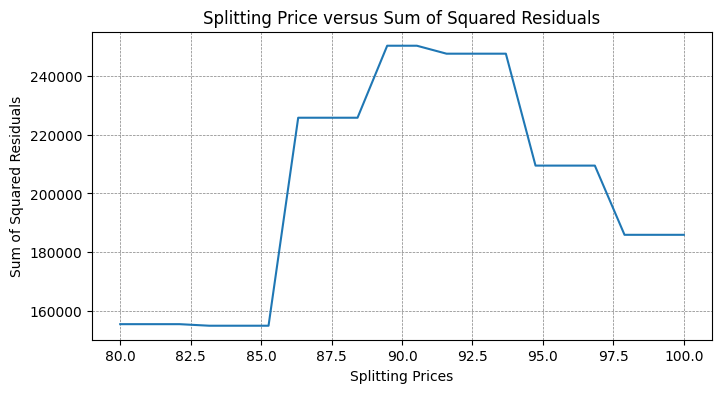

In [31]:
splitting_values = np.linspace(80, 100, 20)                     # Generate an array of splitting values from 80 to 100 with 20 evenly spaced points
ssr_values = []                                                 # Initialize an empty list to store SSR values

# Calculate SSR for each splitting value
for splitting_value in splitting_values:                       
    ssr = (cal_ssr(revenue[prices < splitting_value]) +         # Calculate SSR for prices less than the splitting value
           cal_ssr(revenue[prices > splitting_value]))          # Calculate SSR for prices greater than the splitting value
    ssr_values.append(ssr)                                      # Append the SSR to the list

plt.figure(figsize=(8, 4))                                      # Set the figure size
plt.xlabel("Splitting Prices")                                  # Label the x-axis
plt.ylabel("Sum of Squared Residuals")                          # Label the y-axis
plt.title("Splitting Price versus Sum of Squared Residuals")    # Add a title to the plot

plt.grid(visible=True, linestyle='--', linewidth=0.5, color='grey')  # Add grid lines

plt.plot(splitting_values, ssr_values);                         # Plot splitting values against their corresponding SSRs

#### Splitting on the second node at depth 1

In [33]:
root_splitting_value = 85                                 # Define the root splitting value for the initial division
prices_right = prices[prices > root_splitting_value]      # Filter prices greater than the root splitting value

prices_right

array([ 85.71428571,  88.57142857,  91.42857143,  94.28571429,
        97.14285714, 100.        ])

In [34]:
revenue_right = revenue[prices > root_splitting_value]    # Filter corresponding revenue values for prices greater than the root splitting value

np.mean(revenue_right[prices_right < 93])                 # Calculate the mean revenue for prices in the right split that are less than 93

800.0

In [35]:
np.mean(revenue_right[prices_right > 93])

609.5238095238096

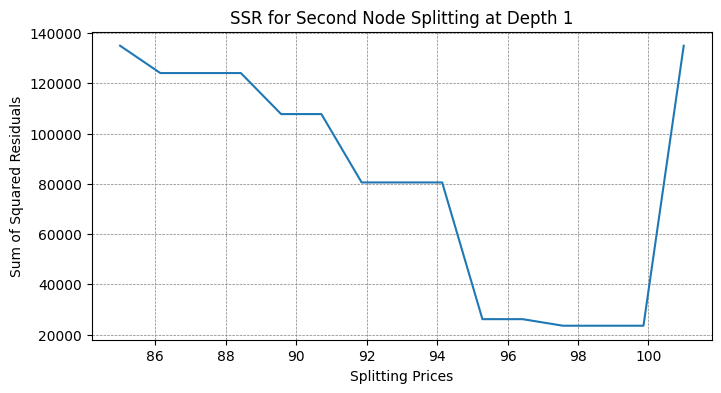

In [36]:
splitting_values = np.linspace(85, 101, 15)                      # Define splitting values from 85 to 101 with 15 evenly spaced points
ssr_values = []                                                  # Initialize an empty list to store SSR values

for splitting_value in splitting_values:                         # Iterate through each splitting value
    
    # Calculate SSR for the left and right splits based on the current splitting value
    ssr = (cal_ssr(revenue_right[prices_right < splitting_value]) + 
           cal_ssr(revenue_right[prices_right > splitting_value]))
    
    ssr_values.append(ssr)                                       # Append the calculated SSR to the list

plt.figure(figsize=(8, 4))                                       # Create a figure with specified size
plt.xlabel("Splitting Prices")                                   # Label the x-axis
plt.ylabel("Sum of Squared Residuals")                           # Label the y-axis
plt.title("SSR for Second Node Splitting at Depth 1")            # Add a title to the plot
plt.grid(visible=True, linestyle='--', linewidth=0.5, color='grey')  # Add grid lines

plt.plot(splitting_values, ssr_values);                          # Plot splitting values against their corresponding SSR values

#### Final look

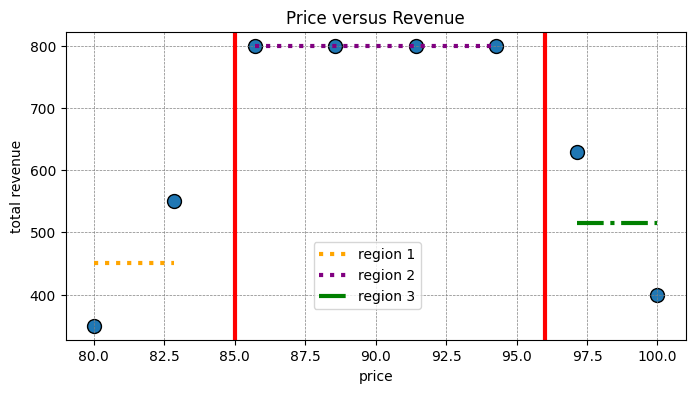

In [38]:
plt.figure(figsize=(8,4))                              # Create a figure with size 8x4 inches

plt.scatter(prices, revenue, s=100, edgecolor='black') # Scatter plot of prices vs. revenue with black-edged markers

plt.xlabel("price")                                    # Label the x-axis as "price"
plt.ylabel("total revenue")                            # Label the y-axis as "total revenue"
plt.title("Price versus Revenue")                      # Add a title to the plot

threshold1 = 85                                        # Set the first threshold for dividing regions
threshold2 = 96                                        # Set the second threshold for dividing regions

num_left = sum(prices < threshold1)                                                # Count the number of prices below the first threshold
ave_left = np.mean(revenue[prices < threshold1])                                   # Calculate the average revenue for prices below the first threshold
num_mid = sum(np.logical_and(prices > threshold1, prices < threshold2))            # Count prices in the middle region
ave_mid = np.mean(revenue[np.logical_and(prices > threshold1, prices < threshold2)])  # Calculate average revenue for middle region
num_right = sum(prices > threshold2)                                               # Count the number of prices above the second threshold
ave_right = np.mean(revenue[prices > threshold2])                                  # Calculate the average revenue for prices above the second threshold

plt.axvline(threshold1, color="red", linewidth=3)      # Draw a vertical red line at threshold1
plt.axvline(threshold2, color="red", linewidth=3)      # Draw a vertical red line at threshold2

plt.plot(prices[prices < threshold1],                  # Select prices below the first threshold for the x-axis
         [ave_left for _ in range(num_left)],          # Create a list of average revenue for region 1 as y-axis values
         linewidth=3,                                  # Set the line width to 3 for better visibility
         linestyle=":",                                # Use a dotted line style for the plot
         c="orange",                                   # Set the line color to orange
         label="region 1")                             # Add a label for the region in the legend

plt.plot(prices[np.logical_and(prices > threshold1, prices < threshold2)],  # Select prices between the first and second thresholds for the x-axis
         [ave_mid for _ in range(num_mid)],                                  # Create a list of average revenue for region 2 as y-axis values
         linewidth=3,                                                        # Set the line width to 3 for better visibility
         linestyle=":",                                                      # Use a dotted line style for the plot
         c="purple",                                                         # Set the line color to purple
         label="region 2")                                                   # Add a label for the region in the legend

plt.plot(prices[prices > threshold2],                 # Select prices above the second threshold for the x-axis
         [ave_right for _ in range(num_right)],       # Create a list of average revenue for region 3 as y-axis values
         linewidth=3,                                 # Set the line width to 3 for better visibility
         linestyle="-.",                              # Use a dashed-dotted line style for the plot
         c="green",                                   # Set the line color to green
         label="region 3")                            # Add a label for the region in the legend

plt.legend(loc=[0.4,0.1])                             # Add a legend to the plot at a specified location

plt.grid(visible=True, linestyle='--', linewidth=0.5, color='grey')  # Add grid lines

#plt.savefig("B15247_10_18.png")

# Scikit-learn APi

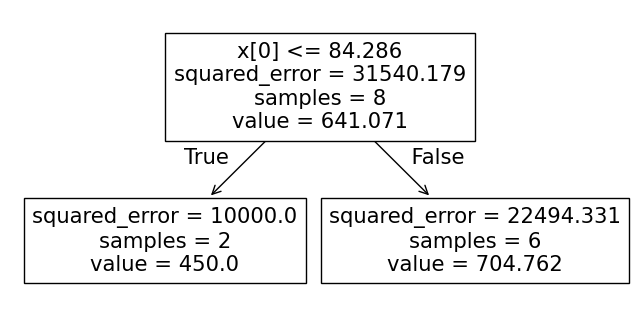

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

prices, revenue = prices.reshape(-1,1), revenue.reshape(-1,1) # Reshape the prices and revenue arrays to 2D arrays for compatibility with the regressor

regressor = DecisionTreeRegressor(random_state=0,             # Initialize a DecisionTreeRegressor with a fixed random state for reproducibility
                                  max_depth=1)                # Set the maximum depth of the tree to 1 for a simple model

regressor.fit(prices, revenue)                                # Fit the decision tree regressor to the prices and revenue data

plt.figure(figsize=(8,4))
tree.plot_tree(regressor);

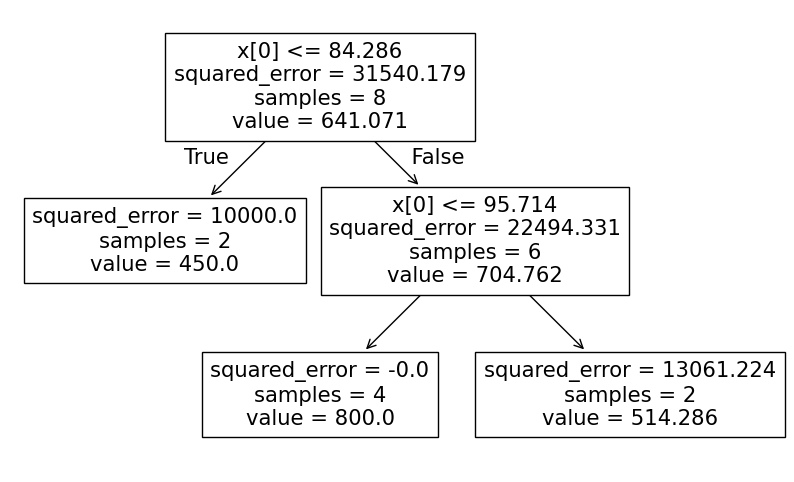

In [41]:
prices, revenue = prices.reshape(-1,1), revenue.reshape(-1,1) # Reshape prices and revenue into 2D arrays to meet scikit-learn's input requirements

regressor = DecisionTreeRegressor(random_state=0,             # Initialize a DecisionTreeRegressor with a fixed random state for reproducibility
                                  max_depth=2,                # Set the maximum depth of the tree to 2 to allow for more splits
                                  min_samples_leaf=2)         # Ensure each leaf node contains at least 2 samples

regressor.fit(prices, revenue)                                # Fit the decision tree regressor to the prices and revenue data

plt.figure(figsize=(10,6))
tree.plot_tree(regressor);